In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['MS Gothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

In [15]:
df = pd.read_csv('fa-1_r2.csv')
display(df)

,com,sporty,reliable,refined,creative,stylish,high_tech
0,A,7,3,7,4,5,3
1,B,6,2,5,2,6,1
2,C,6,8,6,8,9,10
3,D,2,10,1,10,3,10
4,E,3,8,3,8,2,6
5,F,5,9,5,9,3,12
6,G,9,10,11,8,10,11
7,H,2,1,1,1,5,0
8,I,3,2,1,8,7,2
9,J,3,5,3,6,3,5


In [16]:
X = df.drop('com', axis=1)
print(X.shape)
print(X.head())

(10, 6)
   sporty  reliable  refined  creative  stylish  high_tech
0       7         3        7         4        5          3
1       6         2        5         2        6          1
2       6         8        6         8        9         10
3       2        10        1        10        3         10
4       3         8        3         8        2          6


In [17]:
chi_square_value, p_value = calculate_bartlett_sphericity(X)
print(f"Bartlett's test: χ² = {chi_square_value:.2f}, p-value = {p_value:.4f}")

kmo_all, kmo_model = calculate_kmo(X)
print(f"KMO = {kmo_model:.4f}")

Bartlett's test: χ² = 52.43, p-value = 0.0000
KMO = 0.6080


In [18]:
fa_temp = FactorAnalyzer(n_factors=X.shape[1], rotation=None)
fa_temp.fit(X)
ev, v = fa_temp.get_eigenvalues()
print("固有値:")
for i, eigenvalue in enumerate(ev):
    print(f"Factor {i+1}: {eigenvalue:.4f}")

固有値:
Factor 1: 3.1434
Factor 2: 2.1691
Factor 3: 0.4975
Factor 4: 0.1393
Factor 5: 0.0399
Factor 6: 0.0107


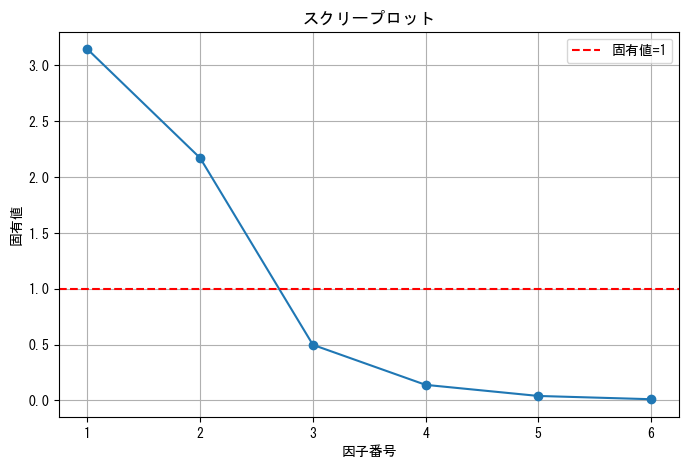


固有値>1の因子数: 2


In [19]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(ev)+1), ev, 'o-')
plt.axhline(y=1, color='r', linestyle='--', label='固有値=1')
plt.xlabel('因子番号')
plt.ylabel('固有値')
plt.title('スクリープロット')
plt.grid(True)
plt.legend()
plt.show()

n_factors_eigen1 = np.sum(ev > 1)
print(f"\n固有値>1の因子数: {n_factors_eigen1}")

In [20]:
fa = FactorAnalyzer(n_factors=2, method='ml', rotation='promax')
fa.fit(X)

loadings = fa.loadings_
loadings_df = pd.DataFrame(
    loadings,
    index=X.columns,
    columns=['Factor1', 'Factor2']
)
print("因子負荷量:")
print(loadings_df)
print()

因子負荷量:
            Factor1   Factor2
sporty     0.030458  0.992924
reliable   0.989649  0.049082
refined    0.180612  0.944490
creative   0.853848 -0.169370
stylish   -0.138270  0.682082
high_tech  0.933129  0.148691



In [21]:
communalities = fa.get_communalities()
communalities_df = pd.DataFrame({
    '項目': X.columns,
    '共通性': communalities,
    '説明できない割合': 1 - communalities
})
print("共通性と説明できない割合:")
print(communalities_df.sort_values('説明できない割合', ascending=False))
print()

# 説明できない割合が最大の項目
max_unexplained_item = communalities_df.loc[communalities_df['説明できない割合'].idxmax(), '項目']
print(f"上位2つの共通因子で説明できない割合がもっとも大きい項目: {max_unexplained_item}")

共通性と説明できない割合:
          項目       共通性  説明できない割合
4    stylish  0.484354  0.515646
3   creative  0.757743  0.242257
5  high_tech  0.892839  0.107161
2    refined  0.924682  0.075318
1   reliable  0.981814  0.018186
0     sporty  0.986827  0.013173

上位2つの共通因子で説明できない割合がもっとも大きい項目: stylish


In [22]:
variance = fa.get_factor_variance()
variance_df = pd.DataFrame(
    variance,
    index=['分散', '寄与率', '累積寄与率'],
    columns=['Factor1', 'Factor2']
)
print("分散、寄与率、累積寄与率:")
print(variance_df)
print()

cumulative_variance = variance[2][1] * 100
print(f"上位2つの共通因子の累積寄与率: {cumulative_variance:.1f}%")

分散、寄与率、累積寄与率:
        Factor1   Factor2
分散     2.631858  2.396400
寄与率    0.438643  0.399400
累積寄与率  0.438643  0.838043

上位2つの共通因子の累積寄与率: 83.8%


In [23]:
factor_scores = fa.transform(X)
factor_scores_df = pd.DataFrame(
    factor_scores,
    columns=['Factor1', 'Factor2']
)
factor_scores_df['com'] = df['com'].values
print("因子得点:")
print(factor_scores_df)

因子得点:
    Factor1   Factor2 com
0 -0.880416  1.092715   A
1 -1.175921  0.632556   B
2  0.636153  0.595617   C
3  1.290110 -1.224708   D
4  0.653698 -0.719462   E
5  0.973201  0.135619   F
6  1.136738  1.958193   G
7 -1.373869 -1.083433   H
8 -1.064639 -0.715757   I
9 -0.195056 -0.671339   J


In [24]:
def biplot_fa(fa, X, labels=None):
    # 因子得点
    scores = fa.transform(X)
    
    # 因子負荷量
    loadings = fa.loadings_
    
    # プロットの作成
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # 因子得点のプロット
    ax.scatter(scores[:, 0], scores[:, 1], alpha=0.6, s=100)
    
    # ラベルの追加
    if labels is None:
        labels = range(len(scores))
    for i, label in enumerate(labels):
        ax.annotate(label, (scores[i, 0], scores[i, 1]), 
                   fontsize=12, ha='center', va='bottom')
    
    # 因子負荷量ベクトルのプロット
    scale = np.max(np.abs(scores)) / np.max(np.abs(loadings)) * 0.8
    for i, var in enumerate(X.columns):
        ax.arrow(0, 0, 
                loadings[i, 0] * scale, 
                loadings[i, 1] * scale,
                head_width=0.1, head_length=0.1,
                fc='red', ec='red', alpha=0.7)
        ax.text(loadings[i, 0] * scale * 1.15, 
               loadings[i, 1] * scale * 1.15,
               var, color='red', fontsize=11, 
               ha='center', va='center',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))
    
    # 軸の設定
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    ax.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
    ax.set_xlabel('Factor 1', fontsize=12)
    ax.set_ylabel('Factor 2', fontsize=12)
    ax.set_title('Biplot (因子得点と因子負荷量)', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [25]:
print("\n第1共通因子(Factor1)との関連:")
print(loadings_df['Factor1'].abs().sort_values(ascending=False))
print("\n第1共通因子と強く関連する項目(|負荷量| > 0.5):")
factor1_related = loadings_df[loadings_df['Factor1'].abs() > 0.5].index.tolist()
print(factor1_related)


第1共通因子(Factor1)との関連:
reliable     0.989649
high_tech    0.933129
creative     0.853848
refined      0.180612
stylish      0.138270
sporty       0.030458
Name: Factor1, dtype: float64

第1共通因子と強く関連する項目(|負荷量| > 0.5):
['reliable', 'creative', 'high_tech']
